# 0 Getting data and installing libraries

## Getting data and unzipping

In [1]:
# !wget https://www.kaggle.com/api/v1/datasets/download/prasunroy/natural-images

In [2]:
# !unzip natural-images

## Requirments installation

In [31]:
!nvidia-smi

Sun Mar  9 19:39:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    Off |   00000000:00:1E.0 Off |                    0 |
|  0%   28C    P8             16W /  300W |       4MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [38]:
!pip install 'tensorflow[and-cuda]'

In [39]:
!export CUDA_VISIBLE_DEVICES=0,1

In [43]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.11.0
Num GPUs Available:  0


In [42]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

# Your output is probably something like ['/device:CPU:0']
# It should be ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0']


2025-03-09 19:43:45.054843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 19:43:45.057153: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
!pip3 install pandas numpy ipyplot split-folders matplotlib scipy==1.11.4 pydot

# 1 EDA

In [7]:
import os
import numpy as np
import scipy
from tensorflow import keras
from keras import layers
from PIL import Image
import splitfolders
import shutil

In [8]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1.1 Let's take a look at couple of images

In [9]:
from keras.utils import load_img

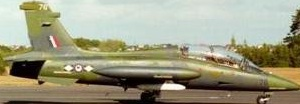

In [10]:
load_img('data/natural_images/airplane/airplane_0000.jpg')

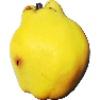

In [11]:
load_img('data/natural_images/fruit/fruit_0002.jpg')

## 1.2 All different classes:

In [12]:
images_folder = 'data/natural_images/'
image_classes = os.listdir(images_folder)
print(f"All image classes: {image_classes}")

All image classes: ['airplane', 'car', 'flower', 'fruit', 'person', 'dog', 'motorbike', 'cat']


/home/ubuntu/capstone/venv/lib/python3.10/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



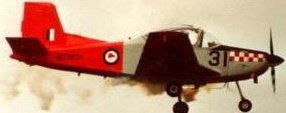
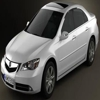
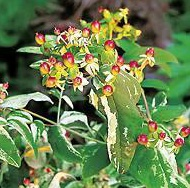
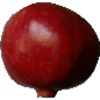
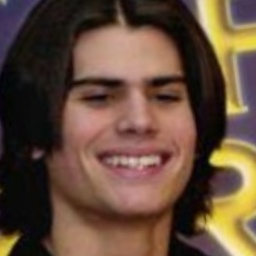
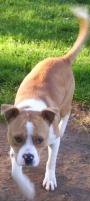
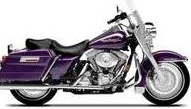
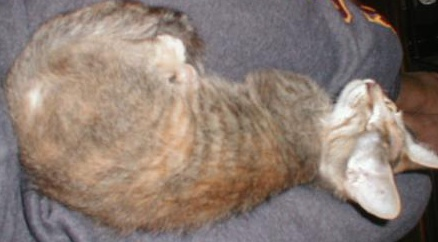


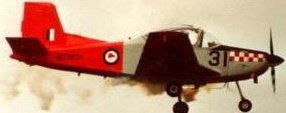
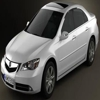
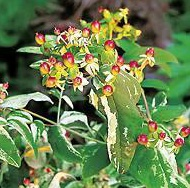
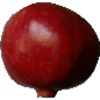
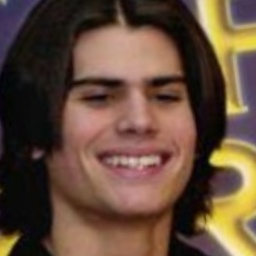
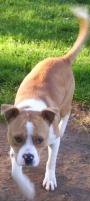
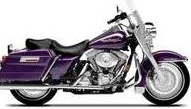
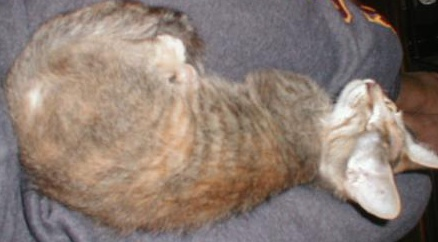

In [13]:
import ipyplot
images_array = [Image.open(f"{images_folder}/{class_name}/{class_name}_0001.jpg") for class_name in image_classes]
ipyplot.plot_images(images_array, labels=image_classes)

## 1.3 Let's see how many images of each class we have

In [14]:
classes_sizes = {}
for class_name in image_classes:
    class_size = len(os.listdir(images_folder + '/' + class_name))
    classes_sizes[class_name] = class_size

<BarContainer object of 8 artists>

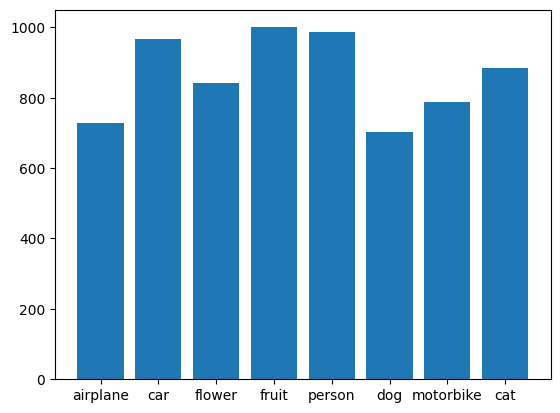

In [15]:
from matplotlib import pyplot as plt
plt.bar(*zip(*classes_sizes.items()))

In [16]:
biggest_class = max(classes_sizes, key=classes_sizes.get)
smallest_class = min(classes_sizes, key=classes_sizes.get)
print(f"Biggest class is {biggest_class} with {classes_sizes[biggest_class]}")
print(f"Small class is {smallest_class} with {classes_sizes[smallest_class]}")

Biggest class is fruit with 1000
Small class is dog with 702


It looks like classes are pretty ballanced.

### 1.4 Let's look at images sizes:

In [17]:
for image in images_array:
    print(np.array(image).shape)

(113, 286, 3)
(100, 100, 3)
(188, 190, 3)
(100, 100, 3)
(256, 256, 3)
(201, 90, 3)
(109, 191, 3)
(242, 438, 3)


Seems like all images have different sizes. During the training (and fine tuning) let's makes them all 150 by 150 and then after let's make them 224 by 224 to test on test dataset

# 2. Train test split

Let's split our data to train, validation and test with 60%, 20% and 20% of each class. We will also shuffle images during splitting.

In [18]:
input_folder = images_folder
output_folder = "prepared_data"
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

splitfolders.ratio(input_folder, output=output_folder, seed=SEED, ratio=(0.6, 0.2, 0.2))

In [19]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)
val_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 4136 files belonging to 8 classes.
Found 1377 files belonging to 8 classes.


2025-03-09 19:20:44.008121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 3. Models

# 3.1 Testing base imagenet model

In [20]:
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

We need to resize the image to 299x299 for it to be used with imagenet

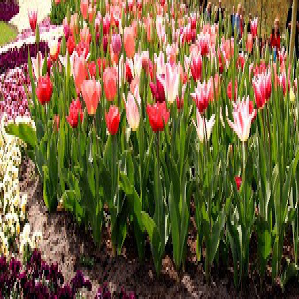

In [21]:
image_path = f"{output_folder}/train/flower/"
fullpath = image_path + os.listdir(image_path)[0]
image = load_img(fullpath, target_size=(299, 299))
image

In [22]:
print(image)

<PIL.Image.Image image mode=RGB size=299x299 at 0x7FD87CB18280>


In [23]:
x = np.array(image)
x.shape

(299, 299, 3)

In [24]:
X = np.array([x]) 

In [25]:
X = preprocess_input(X)

In [26]:
# Let's load original model and look at her predictions
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

In [27]:
pred = model.predict(X)

2025-01-19 16:15:23.059085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-01-19 16:15:23.704408: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-19 16:15:23.705127: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-19 16:15:23.705166: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-01-19 16:15:23.705878: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-19 16:15:23.705963: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


In [28]:
decode_predictions(pred)

[[('n03814906', 'necklace', 0.9150287),
  ('n04153751', 'screw', 0.061060958),
  ('n03942813', 'ping-pong_ball', 0.018071493),
  ('n02834397', 'bib', 0.0038628941),
  ('n04517823', 'vacuum', 0.00042830067)]]

This prediction is a complete nonsence. So we will have to train Dense layers of imagenet onse again on our classes

## 3.2 Retraining top level of Imagenet
Essentially we gonna do the same thing we did during lecture 8:
Take Imagenet as basis, delete top of the model (dense layers) and train them once again on our classes. 

In [29]:
base_model = Xception(
    weights='imagenet', 
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False # We don't want to retrain the model

In [30]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

In [31]:
outputs = base

model = keras.Model(inputs, outputs)

In [32]:
s = train_ds.take(1)
print(s)

<TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>


In [33]:
preds = model.predict(s)
preds.shape # outputs (32, 5, 5, 2048)

1/1 [==============================] - 2s 2s/step


(32, 5, 5, 2048)

In [34]:
def make_model_0(learning_rate=0.1):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(8)(vectors)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [35]:
scores = {}
lr = 0.001

model = make_model_0(learning_rate = lr)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
130/130 [==============================] - 13s 80ms/step - loss: 3.2558 - accuracy: 0.5288 - val_loss: 2.0414 - val_accuracy: 0.6057
Epoch 2/10
130/130 [==============================] - 9s 69ms/step - loss: 1.3268 - accuracy: 0.7072 - val_loss: 1.4768 - val_accuracy: 0.6797
Epoch 3/10
130/130 [==============================] - 9s 69ms/step - loss: 1.0779 - accuracy: 0.7447 - val_loss: 1.1842 - val_accuracy: 0.7444
Epoch 4/10
130/130 [==============================] - 9s 69ms/step - loss: 1.0251 - accuracy: 0.7689 - val_loss: 1.2370 - val_accuracy: 0.7436
Epoch 5/10
130/130 [==============================] - 9s 69ms/step - loss: 0.7932 - accuracy: 0.8049 - val_loss: 1.4662 - val_accuracy: 0.7262
Epoch 6/10
130/130 [==============================] - 9s 68ms/step - loss: 0.6601 - accuracy: 0.8266 - val_loss: 1.0426 - val_accuracy: 0.7821
Epoch 7/10
130/130 [==============================] - 9s 69ms/step - loss: 0.5727 - accuracy: 0.8382 - val_loss: 1.1956 - val_accuracy: 0.777

In [36]:
scores[lr] = history.history

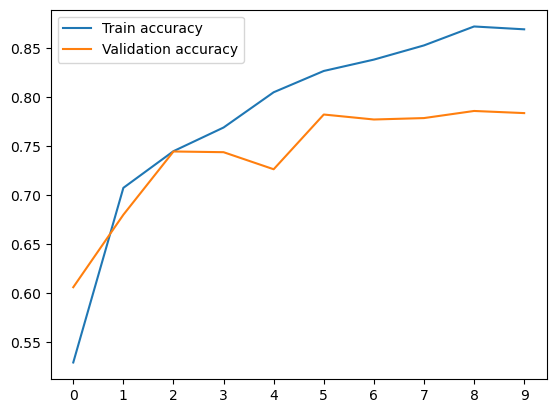

In [37]:
for lr, hist in scores.items():
    plt.plot(scores[0.001]['accuracy'], label='Train accuracy')
    plt.plot(scores[0.001]['val_accuracy'], label='Validation accuracy')
    
plt.xticks(np.arange(10))
plt.legend()

In [38]:
max(scores[0.001]['val_accuracy'])

0.7857661843299866

We can see that top accuracy for validation dataset was reached during epoch 6 with val_accuracy equal to 79.7%. 
After epoch 6 model start to be heavily overfitted.

## 3.3 Parameters tuning

### 3.3.1 Let's try training model with different learning rates

In [39]:
for lr in [0.0001, 0.01, 0.1, 1.0]:
    print(lr)
    model = make_model_0(learning_rate = lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

0.0001
Epoch 1/10
130/130 [==============================] - 12s 75ms/step - loss: 8.8881 - accuracy: 0.1765 - val_loss: 4.6422 - val_accuracy: 0.2992
Epoch 2/10
130/130 [==============================] - 9s 69ms/step - loss: 3.6013 - accuracy: 0.3861 - val_loss: 2.8841 - val_accuracy: 0.4691
Epoch 3/10
130/130 [==============================] - 9s 69ms/step - loss: 2.5261 - accuracy: 0.5015 - val_loss: 2.2605 - val_accuracy: 0.5410
Epoch 4/10
130/130 [==============================] - 9s 69ms/step - loss: 2.0230 - accuracy: 0.5679 - val_loss: 1.9401 - val_accuracy: 0.5897
Epoch 5/10
130/130 [==============================] - 9s 70ms/step - loss: 1.7065 - accuracy: 0.6066 - val_loss: 1.6584 - val_accuracy: 0.6151
Epoch 6/10
130/130 [==============================] - 9s 70ms/step - loss: 1.4868 - accuracy: 0.6422 - val_loss: 1.5178 - val_accuracy: 0.6463
Epoch 7/10
130/130 [==============================] - 9s 70ms/step - loss: 1.3277 - accuracy: 0.6668 - val_loss: 1.3984 - val_accuracy

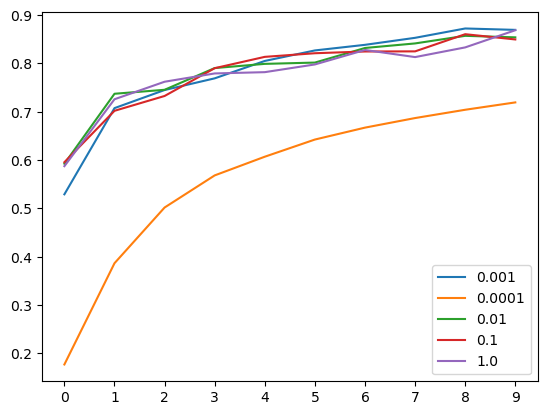

In [40]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=f'{lr}')
    
plt.xticks(np.arange(10))
plt.legend()

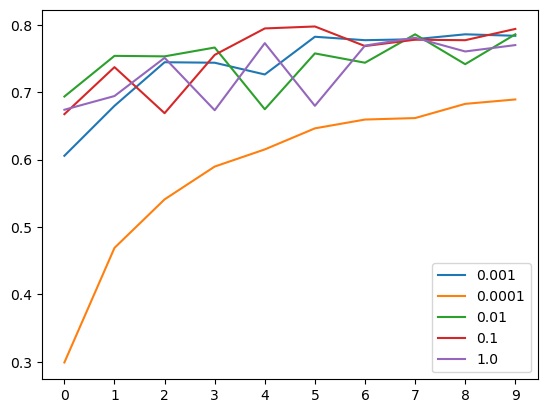

In [41]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'{lr}')
    
plt.xticks(np.arange(10))
plt.legend()

We can see that most of the learning rates give similar results, but 0.01 gets lucky on iteration 8. In my opinion lr = 0.001 gives the highest and the most stable result, so we will use it. 

In [42]:
max(scores[0.001]['val_accuracy'])

0.7857661843299866

In [43]:
best_lr = 0.001

### 3.3.2 Let's also try changing dense layers structure

In [44]:
def make_model_1(learning_rate=0.1, inner_layer_size=100):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner_layer = keras.layers.Dense(inner_layer_size, activation='relu')(vectors)
    outputs = keras.layers.Dense(8)(inner_layer)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [45]:
model = make_model_1(learning_rate=best_lr, inner_layer_size=100)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
130/130 [==============================] - 12s 76ms/step - loss: 2.8395 - accuracy: 0.5619 - val_loss: 1.0908 - val_accuracy: 0.7015
Epoch 2/10
130/130 [==============================] - 9s 70ms/step - loss: 0.9903 - accuracy: 0.7188 - val_loss: 0.9554 - val_accuracy: 0.7168
Epoch 3/10
130/130 [==============================] - 9s 70ms/step - loss: 0.7718 - accuracy: 0.7662 - val_loss: 0.7772 - val_accuracy: 0.7734
Epoch 4/10
130/130 [==============================] - 9s 70ms/step - loss: 0.6447 - accuracy: 0.7950 - val_loss: 0.8937 - val_accuracy: 0.7480
Epoch 5/10
130/130 [==============================] - 9s 71ms/step - loss: 0.5161 - accuracy: 0.8286 - val_loss: 0.7503 - val_accuracy: 0.7879
Epoch 6/10
130/130 [==============================] - 9s 70ms/step - loss: 0.4269 - accuracy: 0.8520 - val_loss: 0.7791 - val_accuracy: 0.7727
Epoch 7/10
130/130 [==============================] - 9s 70ms/step - loss: 0.4216 - accuracy: 0.8506 - val_loss: 0.6785 - val_accuracy: 0.791

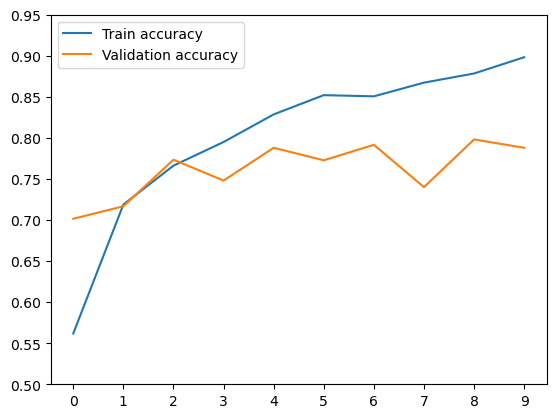

In [46]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    
plt.xticks(np.arange(10))
plt.yticks(np.arange(0.5,1,0.05))
plt.legend()

In [47]:
max(history.history['val_accuracy'])

0.7981118559837341

It seems to improve our results just a little bit: 79.5%

**Maybe let's play with dense layer size:**

In [48]:
scores = {}
for ils in [100, 200, 500, 1000]:
    print(ils)
    model = make_model_1(learning_rate=best_lr, inner_layer_size=ils)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[ils] = history.history

100
Epoch 1/10
130/130 [==============================] - 12s 76ms/step - loss: 2.8705 - accuracy: 0.5754 - val_loss: 1.4311 - val_accuracy: 0.6572
Epoch 2/10
130/130 [==============================] - 9s 71ms/step - loss: 1.0036 - accuracy: 0.7253 - val_loss: 1.1890 - val_accuracy: 0.7226
Epoch 3/10
130/130 [==============================] - 9s 69ms/step - loss: 0.8502 - accuracy: 0.7515 - val_loss: 0.7709 - val_accuracy: 0.7720
Epoch 4/10
130/130 [==============================] - 9s 70ms/step - loss: 0.6426 - accuracy: 0.7942 - val_loss: 0.8274 - val_accuracy: 0.7662
Epoch 5/10
130/130 [==============================] - 9s 70ms/step - loss: 0.5575 - accuracy: 0.8143 - val_loss: 0.7518 - val_accuracy: 0.7829
Epoch 6/10
130/130 [==============================] - 9s 70ms/step - loss: 0.4173 - accuracy: 0.8566 - val_loss: 0.6753 - val_accuracy: 0.7930
Epoch 7/10
130/130 [==============================] - 9s 70ms/step - loss: 0.3837 - accuracy: 0.8619 - val_loss: 0.6352 - val_accuracy: 0

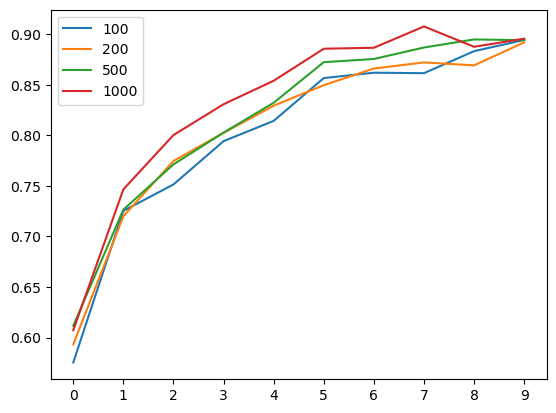

In [49]:
for ils, hist in scores.items():
    plt.plot(hist['accuracy'], label=f'{ils}')
    
plt.xticks(np.arange(10))
# plt.ylim(0.8, 0.9)
# plt.yticks(np.arange(0.7,0.95, 0.02))
plt.legend()

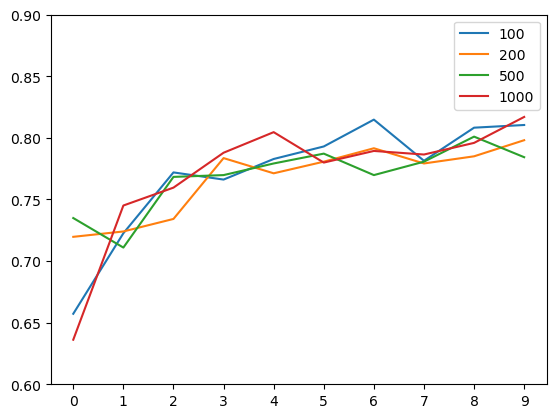

In [50]:
for ils, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'{ils}')
    
plt.xticks(np.arange(10))
plt.yticks(np.arange(0.6,0.9,0.05))
plt.legend()

Results are really similar, but in some cases they cross 80% line. 

In [51]:
for ils, hist in scores.items():
    print(f"{ils}, {max(hist['val_accuracy'])}")

100, 0.8148148059844971
200, 0.7981118559837341
500, 0.8010166883468628
1000, 0.8169934749603271


Inner layer of size 500 seems to be getting the best result for epoch 9.

In [52]:
best_ils = 500

### 3.3.3 Let's try using dropout

In [53]:
def make_model_2(learning_rate=0.1, inner_layer_size=100, droprate=0.2):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner_layer = keras.layers.Dense(100, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner_layer)
    outputs = keras.layers.Dense(8)(drop)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [54]:
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model_2(
        learning_rate=best_lr,
        inner_layer_size=best_ils,
        droprate=droprate
    )
    # we increased number of epochs because we added regularization, which means model will learn slower with each epoch.
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

0.0
Epoch 1/30
130/130 [==============================] - 12s 76ms/step - loss: 2.8009 - accuracy: 0.5687 - val_loss: 1.5158 - val_accuracy: 0.6979
Epoch 2/30
130/130 [==============================] - 9s 69ms/step - loss: 0.9953 - accuracy: 0.7193 - val_loss: 0.8904 - val_accuracy: 0.7487
Epoch 3/30
130/130 [==============================] - 9s 69ms/step - loss: 0.6963 - accuracy: 0.7773 - val_loss: 0.7610 - val_accuracy: 0.7647
Epoch 4/30
130/130 [==============================] - 9s 70ms/step - loss: 0.5644 - accuracy: 0.8068 - val_loss: 0.6701 - val_accuracy: 0.7829
Epoch 5/30
130/130 [==============================] - 9s 70ms/step - loss: 0.4524 - accuracy: 0.8407 - val_loss: 0.7073 - val_accuracy: 0.7879
Epoch 6/30
130/130 [==============================] - 9s 70ms/step - loss: 0.4733 - accuracy: 0.8397 - val_loss: 0.7220 - val_accuracy: 0.7894
Epoch 7/30
130/130 [==============================] - 9s 70ms/step - loss: 0.3715 - accuracy: 0.8682 - val_loss: 0.6647 - val_accuracy: 0

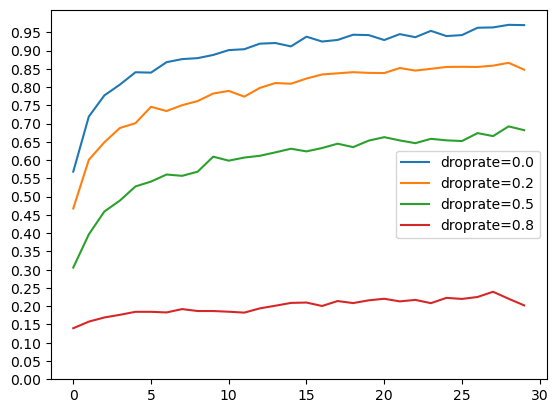

In [55]:
for droprate, hist in scores.items():
    plt.plot(hist['accuracy'], label=f'droprate={droprate}')
    
plt.yticks(np.arange(0.0, 1, 0.05))
plt.legend()

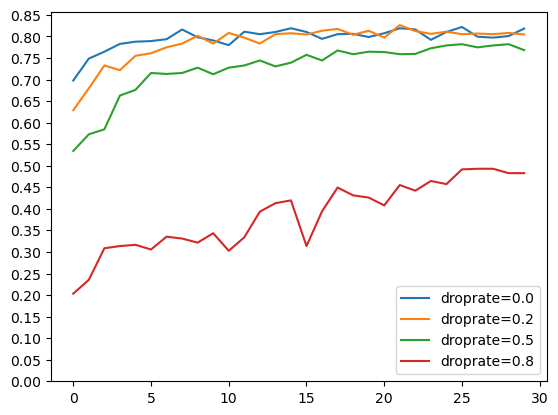

In [56]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'droprate={droprate}')
    
plt.yticks(np.arange(0.0, 0.9, 0.05))
plt.legend()

It seems like droprate of 0.8 gives terrible result, but other droprates are similar in performace. For this reason let's leave droprate ar 0.2

In [57]:
print(max(scores[0.2]['val_accuracy']))

0.8264342546463013


In [58]:
best_droprate = 0.2

We see that best accuracy at this point is 82.6%

### 3.3.4 Let's also try augmenting our images

In [59]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor=0.0833),
    layers.RandomTranslation(height_factor=0.06, width_factor=0.06),
    layers.RandomZoom(0.1),
    layers.RandomFlip(mode="vertical"),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

val_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 4136 files belonging to 8 classes.
Found 1377 files belonging to 8 classes.


In [60]:
model = make_model_2(
    learning_rate=best_lr,
    inner_layer_size=best_ils,
    droprate=best_droprate
)

history = model.fit(train_ds, epochs=60, validation_data=val_ds)

Epoch 1/60
130/130 [==============================] - 31s 216ms/step - loss: 3.5597 - accuracy: 0.3479 - val_loss: 1.4243 - val_accuracy: 0.4800
Epoch 2/60
130/130 [==============================] - 27s 208ms/step - loss: 1.5339 - accuracy: 0.4478 - val_loss: 1.3241 - val_accuracy: 0.5454
Epoch 3/60
130/130 [==============================] - 27s 209ms/step - loss: 1.4188 - accuracy: 0.4778 - val_loss: 1.2681 - val_accuracy: 0.5570
Epoch 4/60
130/130 [==============================] - 27s 210ms/step - loss: 1.3695 - accuracy: 0.5077 - val_loss: 1.2284 - val_accuracy: 0.5396
Epoch 5/60
130/130 [==============================] - 27s 210ms/step - loss: 1.2831 - accuracy: 0.5290 - val_loss: 1.1349 - val_accuracy: 0.5984
Epoch 6/60
130/130 [==============================] - 27s 210ms/step - loss: 1.2241 - accuracy: 0.5440 - val_loss: 1.0801 - val_accuracy: 0.5984
Epoch 7/60
130/130 [==============================] - 28s 211ms/step - loss: 1.2515 - accuracy: 0.5459 - val_loss: 1.1096 - val_ac

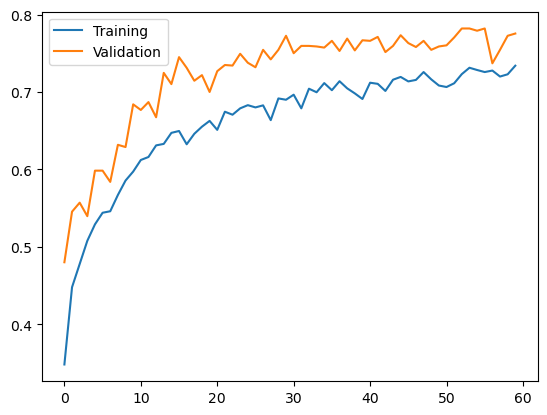

In [61]:
plt.plot(history.history['accuracy'], label=f'Training')
plt.plot(history.history['val_accuracy'], label=f'Validation')
    
plt.legend()

It seems our transformations are no good. Let's try simpler transformations.

In [62]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomFlip(mode="vertical"),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

val_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 4136 files belonging to 8 classes.
Found 1377 files belonging to 8 classes.


In [63]:
model = make_model_2(
    learning_rate=best_lr,
    inner_layer_size=best_ils,
    droprate=best_droprate
)

history = model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
130/130 [==============================] - 17s 111ms/step - loss: 3.0292 - accuracy: 0.4040 - val_loss: 1.3796 - val_accuracy: 0.5396
Epoch 2/30
130/130 [==============================] - 14s 103ms/step - loss: 1.3594 - accuracy: 0.5259 - val_loss: 1.1689 - val_accuracy: 0.6006
Epoch 3/30
130/130 [==============================] - 14s 105ms/step - loss: 1.2328 - accuracy: 0.5684 - val_loss: 1.0336 - val_accuracy: 0.6282
Epoch 4/30
130/130 [==============================] - 14s 103ms/step - loss: 1.1923 - accuracy: 0.5885 - val_loss: 1.0471 - val_accuracy: 0.6398
Epoch 5/30
130/130 [==============================] - 14s 105ms/step - loss: 1.0973 - accuracy: 0.6052 - val_loss: 1.0099 - val_accuracy: 0.6456
Epoch 6/30
130/130 [==============================] - 14s 104ms/step - loss: 1.0726 - accuracy: 0.6151 - val_loss: 0.9249 - val_accuracy: 0.6826
Epoch 7/30
130/130 [==============================] - 13s 102ms/step - loss: 1.0137 - accuracy: 0.6354 - val_loss: 0.8851 - val_ac

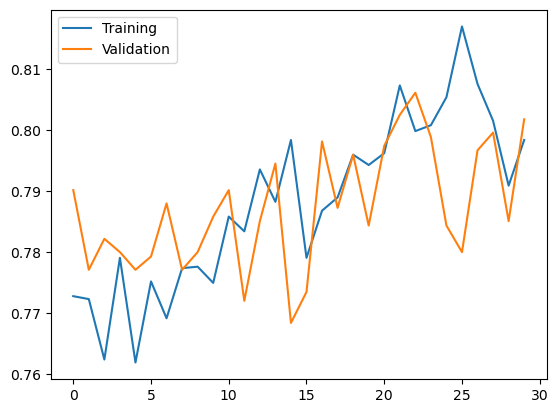

In [65]:
plt.plot(history.history['accuracy'], label=f'Training')
plt.plot(history.history['val_accuracy'], label=f'Validation')
    
plt.legend()

It seems like we are not getting better results with data augmentation unfortunately. 

## 3.4 Let's try swapping imagenet for another model

According to this notebook (https://www.kaggle.com/code/databeru/best-of-27-architectures-to-classify-pics-100-acc) the best model to try is ResNet101V2

In [66]:
def make_model_3(input_shape=(150, 150, 3), learning_rate=0.1, inner_layer_size=100, droprate=0.2):
    base_model = keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
    )
    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner_layer = keras.layers.Dense(inner_layer_size, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner_layer)
    outputs = keras.layers.Dense(8)(drop)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [67]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)

val_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 4136 files belonging to 8 classes.
Found 1377 files belonging to 8 classes.


In [68]:
model = make_model_3(input_shape=(150, 150, 3), learning_rate=0.01, inner_layer_size=200, droprate=0.0)

In [69]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
130/130 [==============================] - 17s 108ms/step - loss: 0.9859 - accuracy: 0.9541 - val_loss: 0.1963 - val_accuracy: 0.9826
Epoch 2/10
130/130 [==============================] - 13s 98ms/step - loss: 0.1381 - accuracy: 0.9838 - val_loss: 0.2552 - val_accuracy: 0.9782
Epoch 3/10
130/130 [==============================] - 13s 98ms/step - loss: 0.0385 - accuracy: 0.9935 - val_loss: 0.1971 - val_accuracy: 0.9818
Epoch 4/10
130/130 [==============================] - 13s 98ms/step - loss: 0.2583 - accuracy: 0.9843 - val_loss: 0.2550 - val_accuracy: 0.9782
Epoch 5/10
130/130 [==============================] - 13s 98ms/step - loss: 0.4460 - accuracy: 0.9790 - val_loss: 0.4636 - val_accuracy: 0.9855
Epoch 6/10
130/130 [==============================] - 13s 99ms/step - loss: 0.2844 - accuracy: 0.9884 - val_loss: 0.7406 - val_accuracy: 0.9760
Epoch 7/10
130/130 [==============================] - 13s 98ms/step - loss: 0.0859 - accuracy: 0.9937 - val_loss: 0.5730 - val_accuracy

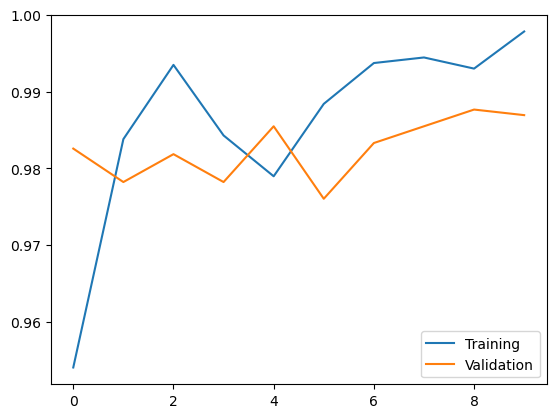

In [70]:
plt.plot(history.history['accuracy'], label=f'Training')
plt.plot(history.history['val_accuracy'], label=f'Validation')
    
plt.legend()

It seems like VGG16 model is actually superior with really high accuracy of like 98%

## 3.5 Let's also try some sequential model with out custom architecture

In [71]:
def make_model_seq_1(input_shape=(150, 150, 3), learning_rate=0.1, droprate=0.25):
    model = keras.Sequential()
    # inputs = keras.Input(shape=(input_size, input_size, 3))

    model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dropout(rate=droprate))
    model.add(layers.Dense(8, activation='softmax'))
    
    # optimizer = keras.optimizers.Adam(learning_rate=learning_rate) 
    # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False) 
    # model.compile(
    #     optimizer=optimizer, 
    #     loss=loss, 
    #     metrics=['accuracy']
    # )
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model

In [72]:
seq_model = make_model_seq_1(input_shape=(150, 150, 3), learning_rate=0.01, droprate=0.2)

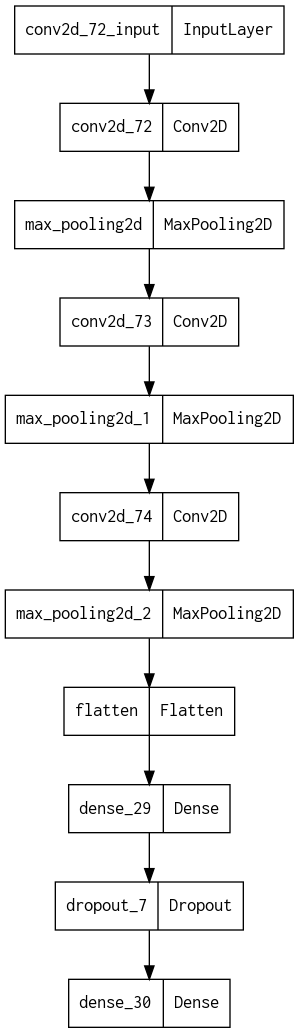

In [73]:
keras.utils.plot_model(seq_model)

In [74]:
history = seq_model.fit(train_ds, epochs=40, validation_data=val_ds)

Epoch 1/40
130/130 [==============================] - 4s 24ms/step - loss: 15.3609 - accuracy: 0.6245 - val_loss: 0.8274 - val_accuracy: 0.7131
Epoch 2/40
130/130 [==============================] - 3s 22ms/step - loss: 0.4841 - accuracy: 0.8382 - val_loss: 0.5770 - val_accuracy: 0.8126
Epoch 3/40
130/130 [==============================] - 3s 22ms/step - loss: 0.2532 - accuracy: 0.9108 - val_loss: 0.5743 - val_accuracy: 0.8315
Epoch 4/40
130/130 [==============================] - 3s 22ms/step - loss: 0.1644 - accuracy: 0.9441 - val_loss: 0.6448 - val_accuracy: 0.8315
Epoch 5/40
130/130 [==============================] - 3s 22ms/step - loss: 0.1253 - accuracy: 0.9611 - val_loss: 0.9079 - val_accuracy: 0.7800
Epoch 6/40
130/130 [==============================] - 3s 22ms/step - loss: 0.2537 - accuracy: 0.9188 - val_loss: 0.8248 - val_accuracy: 0.8134
Epoch 7/40
130/130 [==============================] - 3s 22ms/step - loss: 0.1633 - accuracy: 0.9516 - val_loss: 0.9084 - val_accuracy: 0.785

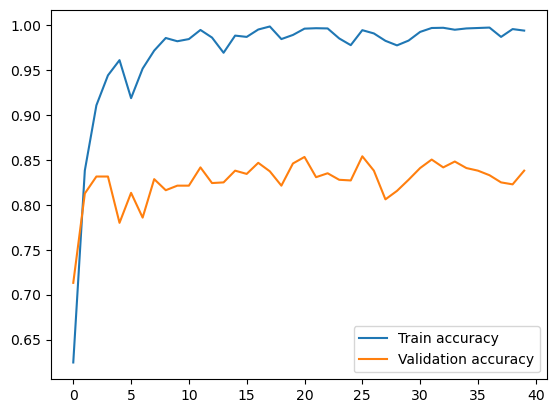

In [75]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

In [76]:
print(f"Best accuracy on validation: {max(history.history['val_accuracy'])}")

Best accuracy on validation: 0.8540304899215698


It seems like this model started to overfit after 20 or something epochs.

## 3.6 Results on 150x150 images

**Results are:**
1. Xception with fine tuning - 82.6%
2. VGG16 - 98%
3. Custom sequential model - 85.4%

# 4. Testing the best model on 224x224 images

In [77]:
def make_final_model(input_shape=(224, 224, 3), learning_rate=0.1, inner_layer_size=100, droprate=0.2):
    base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
    )
    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner_layer = keras.layers.Dense(inner_layer_size, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner_layer)
    outputs = keras.layers.Dense(8)(drop)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [78]:
input_folder = images_folder
output_folder_no_val = "prepared_data_no_val"
if os.path.exists(output_folder_no_val):
    shutil.rmtree(output_folder_no_val)

splitfolders.ratio(input_folder, output=output_folder_no_val, seed=SEED, ratio=(0.8, 0.0, 0.2))

In [79]:
image_size = 224
batch_size = 32

train_val_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder_no_val}/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(image_size, image_size)
)
                                                            
test_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder_no_val}/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(image_size, image_size)
)
class_names = test_ds.class_names
print(f"class_names: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_val_ds = train_val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 5516 files belonging to 8 classes.
Found 1383 files belonging to 8 classes.
class_names: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [80]:
final_model = make_final_model(input_shape=(image_size, image_size, 3), learning_rate=0.01, inner_layer_size=200, droprate=0.2)

In [81]:
final_model.fit(train_val_ds, epochs=10)

Epoch 1/10
173/173 [==============================] - 28s 146ms/step - loss: 0.6932 - accuracy: 0.9483
Epoch 2/10
173/173 [==============================] - 24s 139ms/step - loss: 0.0809 - accuracy: 0.9822
Epoch 3/10
173/173 [==============================] - 24s 140ms/step - loss: 0.0795 - accuracy: 0.9826
Epoch 4/10
173/173 [==============================] - 24s 139ms/step - loss: 0.0732 - accuracy: 0.9851
Epoch 5/10
173/173 [==============================] - 24s 139ms/step - loss: 0.0905 - accuracy: 0.9869
Epoch 6/10
173/173 [==============================] - 24s 140ms/step - loss: 0.1299 - accuracy: 0.9822
Epoch 7/10
173/173 [==============================] - 24s 140ms/step - loss: 0.0796 - accuracy: 0.9888
Epoch 8/10
173/173 [==============================] - 24s 140ms/step - loss: 0.0760 - accuracy: 0.9889
Epoch 9/10
173/173 [==============================] - 24s 140ms/step - loss: 0.1716 - accuracy: 0.9842
Epoch 10/10
173/173 [==============================] - 24s 139ms/step - l

# 5. Testing the model

In [82]:
final_model.evaluate(test_ds)

44/44 [==============================] - 7s 160ms/step - loss: 0.0837 - accuracy: 0.9877


[0.0837496742606163, 0.9877078533172607]

Final accuracy: **98.7%**

In [83]:
from keras.utils import load_img

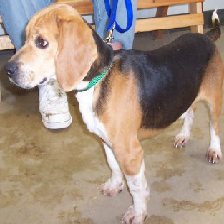

In [84]:
path = f'data/natural_images/dog/dog_0029.jpg'
image = load_img(path, target_size=(image_size, image_size))
image

In [85]:
def predict_image(image, class_names):
    x = np.array(image)
    X = np.array([x])
    pred = final_model.predict(X)
    pred_class_index = pred.argmax(axis=-1)[0]
    return class_names[pred_class_index]

In [86]:
predict_image(image, class_names)

1/1 [==============================] - 1s 710ms/step


'dog'

# 5. Saving the model

Let's save model, load it and test lite version

In [87]:
final_model.save("final_model.h5")

In [88]:
final_model = keras.models.load_model('final_model.h5')

In [89]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
 
tflite_model = converter.convert()

# Saving the model
with open('final_model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5zen_zoj/assets


INFO:tensorflow:Assets written to: /tmp/tmp5zen_zoj/assets
2025-01-19 17:40:32.183923: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-01-19 17:40:32.183974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-01-19 17:40:32.184848: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp5zen_zoj
2025-01-19 17:40:32.189825: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2025-01-19 17:40:32.189869: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmp5zen_zoj
2025-01-19 17:40:32.204842: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-01-19 17:40:32.209440: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2025-01-19 17:40:32.329266: I tensorflow/cc/saved_model/loader.cc:212] Running initializatio

In [90]:
import tensorflow.lite as tflite
 
interpreter = tflite.Interpreter(model_path='final_model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


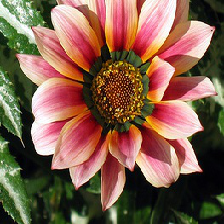

In [91]:
image_size = 224
img_class = 'flower'
path = f'data/natural_images/{img_class}/{img_class}_0030.jpg'
image = load_img(path, target_size=(image_size, image_size))
image

In [92]:
def lite_predict_image(image, class_names):
    x = np.array(image)
    X = np.array([x])
    X = np.float32(X)
    interpreter.set_tensor(input_index, X)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_index)
    pred_class_index = pred.argmax(axis=-1)[0]
    return class_names[pred_class_index]

In [93]:
class_names = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
lite_predict_image(image, class_names)

'flower'

# 6.Test train script

File train.py has the same exact code as following cells, so you can test everything from the same notebook

In [94]:
import os
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import scipy
import shutil
import numpy as np
import splitfolders
from PIL import Image
import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.applications.vgg16 import VGG16


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [95]:
def make_final_model(input_shape=(224, 224, 3), learning_rate=0.1, inner_layer_size=100, droprate=0.2):
    base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
    )
    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner_layer = keras.layers.Dense(inner_layer_size, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner_layer)
    outputs = keras.layers.Dense(8)(drop)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [96]:
def split_the_data(output_folder):
    input_folder = 'data/natural_images'
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    splitfolders.ratio(input_folder, output=output_folder, seed=SEED, ratio=(0.8, 0.0, 0.2))

In [97]:
def train_the_model(output_folder):
    image_size = 224
    batch_size = 32

    train_val_ds = keras.utils.image_dataset_from_directory(
        directory=f'{output_folder_no_val}/train',
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(image_size, image_size)
    )

    test_ds = keras.utils.image_dataset_from_directory(
        directory=f'{output_folder_no_val}/test',
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(image_size, image_size)
    )

    AUTOTUNE = tf.data.AUTOTUNE
    train_val_ds = train_val_ds.prefetch(AUTOTUNE)
    test_ds = test_ds.prefetch(AUTOTUNE)
    
    final_model = make_final_model(input_shape=(image_size, image_size, 3), learning_rate=0.01, inner_layer_size=200, droprate=0.2)
    
    final_model.fit(train_val_ds, epochs=10)
    
    return final_model

In [99]:
def convert_model(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
 
    tflite_model = converter.convert()

    # Saving the model
    with open('final_model.tflite', 'wb') as f_out:
        f_out.write(tflite_model)

In [100]:
output_folder_no_val = "prepared_data_no_val"
split_the_data(output_folder_no_val)
final_model = train_the_model(output_folder_no_val)
convert_model(final_model)

Found 5516 files belonging to 8 classes.
Found 1383 files belonging to 8 classes.
Epoch 1/10
173/173 [==============================] - 25s 140ms/step - loss: 0.8326 - accuracy: 0.9491
Epoch 2/10
173/173 [==============================] - 24s 140ms/step - loss: 0.1276 - accuracy: 0.9837
Epoch 3/10
173/173 [==============================] - 24s 140ms/step - loss: 0.0656 - accuracy: 0.9898
Epoch 4/10
173/173 [==============================] - 24s 139ms/step - loss: 0.0930 - accuracy: 0.9868
Epoch 5/10
173/173 [==============================] - 24s 140ms/step - loss: 0.1460 - accuracy: 0.9853
Epoch 6/10
173/173 [==============================] - 24s 140ms/step - loss: 0.1050 - accuracy: 0.9851
Epoch 7/10
173/173 [==============================] - 24s 140ms/step - loss: 0.0649 - accuracy: 0.9904
Epoch 8/10
173/173 [==============================] - 24s 139ms/step - loss: 0.1537 - accuracy: 0.9857
Epoch 9/10
173/173 [==============================] - 24s 140ms/step - loss: 0.1588 - accuracy

INFO:tensorflow:Assets written to: /tmp/tmp3paf68x6/assets


INFO:tensorflow:Assets written to: /tmp/tmp3paf68x6/assets
2025-01-19 17:49:22.243128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-01-19 17:49:22.243174: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-01-19 17:49:22.243344: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp3paf68x6
2025-01-19 17:49:22.247648: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2025-01-19 17:49:22.247679: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmp3paf68x6
2025-01-19 17:49:22.268384: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2025-01-19 17:49:22.376812: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp3paf68x6
2025-01-19 17:49:22.409921: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

# 7. Explain model

In [33]:
!pip3 install shap numpy==1.23.5 opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 54.7 MB/s eta 0:00:00m eta 0:00:010:00:01


In [251]:
import numpy as np
import shap
import cv2

from tensorflow import keras
import tensorflow.lite as tflite
from keras.utils import load_img

from PIL import Image
import io

In [252]:
class_names = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

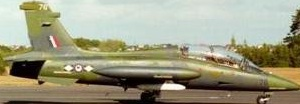

In [253]:
image_path1 = 'data/natural_images/airplane/airplane_0000.jpg'
image1 = load_img(image_path1)
image1

In [254]:
interpreter = tflite.Interpreter(model_path='final_model.tflite')
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [255]:
def preprocess_image(image: Image.Image, target_size=(224, 224)) -> np.ndarray:
    image = image.resize(target_size)
    image = image.convert("RGB")
    X = np.array(image).astype(np.float32) / 255.0  # Normalize to [0,1] for SHAP
    return X

In [256]:
X = np.array([
        preprocess_image(load_img(f'data/natural_images/{cls}/{cls}_0000.jpg'), target_size=(224, 224)) for cls in class_names
    ])
X.shape

(8, 224, 224, 3)

In [284]:
def lite_predict_images(X_batch, class_names):
    preds = []
    for X in X_batch:
        interpreter.set_tensor(input_index, np.array([X]))  
        interpreter.invoke()
        pred = interpreter.get_tensor(output_index)  
        pred = np.exp(pred[0]) / np.sum(np.exp(pred[0]))  # Softmax conversion
        preds.append(pred)
    return np.array(preds)

In [285]:
def predict(preprocessed_image, class_names):
    # image = preprocess_image(image, target_size=(224, 224))
    res = lite_predict_image(preprocessed_image, class_names)
    return res

In [286]:
lite_predict_images(X, class_names)

array([[0.07246201, 0.09183079, 0.2647438 , 0.1681106 , 0.12709354,
        0.06526683, 0.09112123, 0.1193712 ],
       [0.07411621, 0.09767069, 0.224627  , 0.15415008, 0.15416344,
        0.05921537, 0.09595775, 0.14009945],
       [0.02397476, 0.02527916, 0.6860556 , 0.16690058, 0.02226119,
        0.02538706, 0.03058721, 0.0195545 ],
       [0.07577872, 0.08015606, 0.31805557, 0.17816561, 0.08878861,
        0.08656968, 0.08757088, 0.08491492],
       [0.06750427, 0.07605419, 0.30539644, 0.17152384, 0.15482968,
        0.03414153, 0.07779488, 0.11275517],
       [0.07274969, 0.0985586 , 0.21965258, 0.15279603, 0.15947485,
        0.05647531, 0.09529919, 0.14499374],
       [0.06458686, 0.09234118, 0.27164972, 0.17397273, 0.1310003 ,
        0.05496256, 0.08455062, 0.12693602],
       [0.05522951, 0.09641252, 0.24015923, 0.16328484, 0.16676173,
        0.03823537, 0.07887868, 0.16103813]], dtype=float32)

In [287]:
def f(x):
    return lite_predict_images(x, class_names)  # Now properly supports batch inference

We need to sort classes

In [288]:
print(class_names)  # Your expected class order
sample_preds = f(X[0:1])  # Get model output for a sample image
print(sample_preds)  # See if the class order matches class_names

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
[[0.07246201 0.09183079 0.2647438  0.1681106  0.12709354 0.06526683
  0.09112123 0.1193712 ]]


In [289]:
sorted_indices = np.argsort(sample_preds[0])[::-1]  # Sort descending
print("Sorted indices:", sorted_indices)

Sorted indices: [2 3 4 7 1 6 0 5]


In [290]:
corrected_class_names = [class_names[i] for i in sorted_indices]
corrected_class_names

['cat', 'dog', 'flower', 'person', 'car', 'motorbike', 'airplane', 'fruit']

In [298]:
example_image = X[0]   # Use the first image as an example for the masker
masker = shap.maskers.Image(example_image, (224, 224, 3))

In [299]:
explainer = shap.Explainer(f, masker, output_names=class_names)

outputs = list(range(len(class_names)))  # Ensure SHAP processes all class indices
shap_values = explainer(X[0:5], max_evals=500, batch_size=50, outputs=outputs)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|█████████████▊                                                       | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|████████████████████████████████████                        | 3/5 [13:57<06:58, 209.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████████████████████████████████████████████            | 4/5 [20:55<04:56, 296.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████| 5/5 [27:54<00:00, 341.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [34:52, 418.50s/it]                                                                         


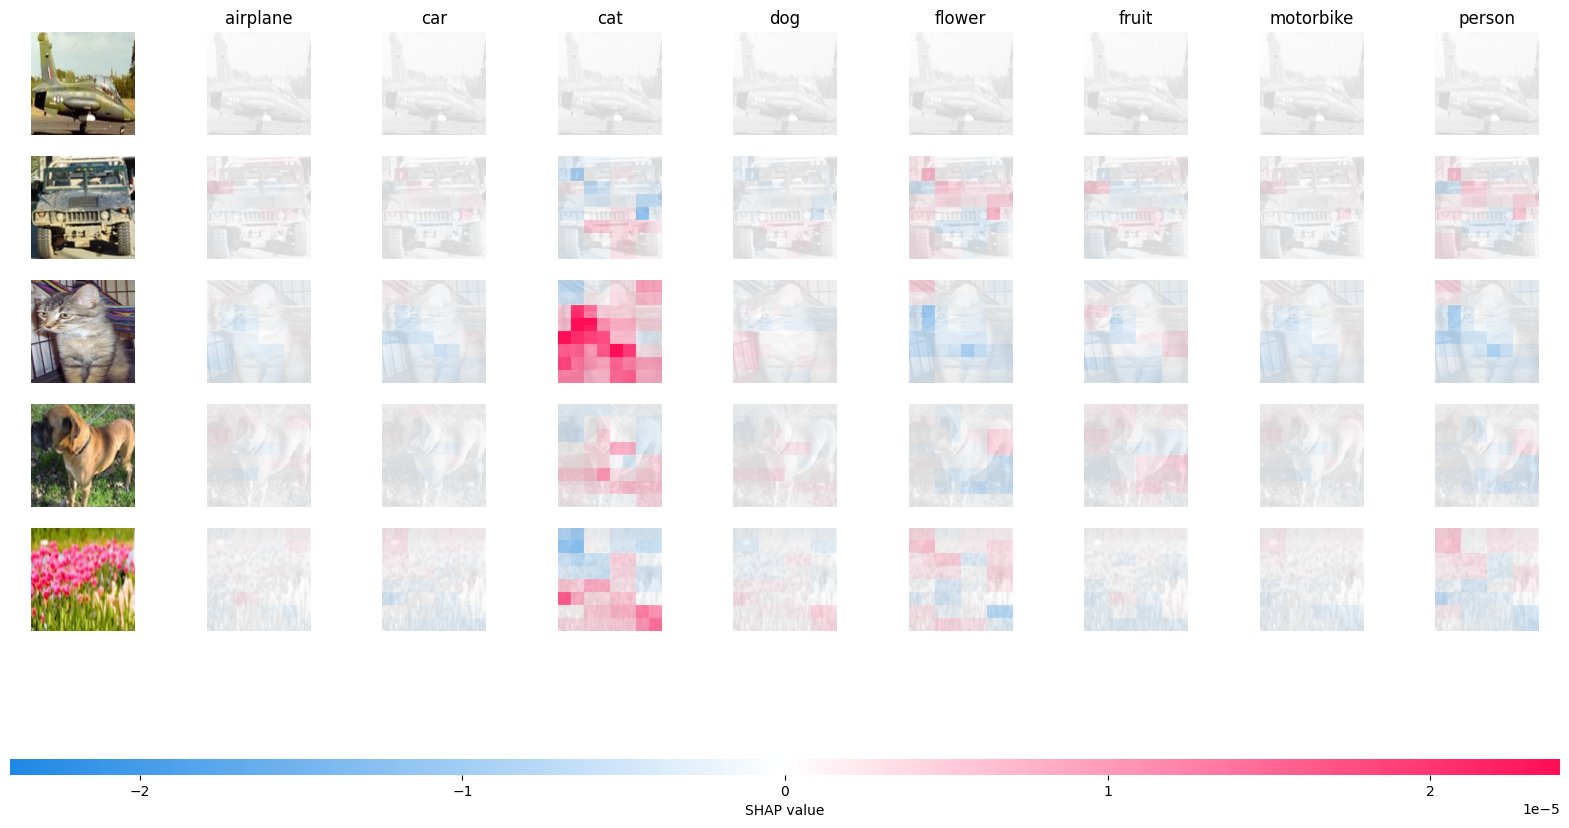

In [300]:
shap.image_plot(shap_values)